# Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt

from sklearn import metrics as skmetrics
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from bayes_opt import BayesianOptimization

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

In [3]:
X_smote = pd.read_csv('data/X_smote.csv')
y_smote = pd.read_csv('data/y_smote.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

# Evaluation Metrics Function

In [4]:
def print_statistics(y_actual, y_pred, dataset_type):
  print(f"====================={dataset_type}====================")
  print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
  print(f"precision: {round(skmetrics.precision_score(y_actual, y_pred),5)}")
  print(f"recall: {round(skmetrics.recall_score(y_actual, y_pred),5)}")
  print(f"f1 score: {round(skmetrics.f1_score(y_actual, y_pred),5)}")
  print(f"roc auc score: {round(skmetrics.roc_auc_score(y_actual, y_pred),5)}")

# Fitting XGBoost model

In [5]:
xgb_model = xgb.XGBClassifier().fit(X_smote, y_smote)

In [6]:
train_pred_xgb = xgb_model.predict(X_smote)
val_pred_xgb = xgb_model.predict(X_val)
test_pred_xgb = xgb_model.predict(X_test)
print_statistics(y_smote, train_pred_xgb, 'train')
print_statistics(y_val, val_pred_xgb, 'val')
print_statistics(y_test, test_pred_xgb, 'test')

=====================train====================
accuracy: 0.97108
precision: 0.98655
recall: 0.95517
f1 score: 0.97061
roc auc score: 0.97108
=====================val====================
accuracy: 0.92676
precision: 0.90791
recall: 0.81105
f1 score: 0.85675
roc auc score: 0.89031
=====================test====================
accuracy: 0.93232
precision: 0.92063
recall: 0.82005
f1 score: 0.86744
roc auc score: 0.89695


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

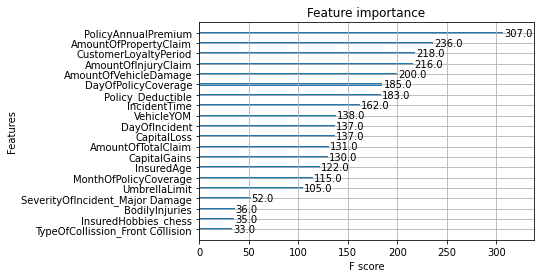

In [7]:
# Top 20 Most Important Features in XGB
xgb.plot_importance(xgb_model, max_num_features=20)

# Choosing the top 90 features

In [8]:
thresholds = sort(xgb_model.feature_importances_)
thres = thresholds[-90]

selection = SelectFromModel(xgb_model, threshold=thres, prefit=True)
select_X_train = selection.transform(X_smote.to_numpy())

# train model
selection_model = xgb.XGBClassifier()
selection_model.fit(select_X_train, y_smote)

# eval model
select_X_val = selection.transform(X_val.to_numpy())
y_pred = selection_model.predict(select_X_val)
predictions = [round(value) for value in y_pred]
print_statistics(y_val, predictions, 'Threshold={}, n={}'.format(thres, select_X_train.shape[1]))

=====================Threshold=0.00201545562595129, n=90====================
accuracy: 0.90663
precision: 0.86724
recall: 0.77249
f1 score: 0.81713
roc auc score: 0.86437


In [9]:
# Getting seelcted features for x test
select_X_test = selection.transform(X_test.to_numpy())

# Hyperparameter Tuning using Bayesian Optimization

In [10]:
seed = 1

def xgbc_func(max_depth,learning_rate,n_estimators,reg_alpha):
    
    estimator_function = xgb.XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = seed)
    # Fit the estimator
    estimator_function.fit(select_X_train, y_smote)
    probs = estimator_function.predict_proba(select_X_val)
    probs = probs[:,1]
    val_roc = skmetrics.roc_auc_score(y_val, probs)
    
    return val_roc

In [11]:
gp_params = {"alpha": 1e-10}

hyperparameter_space = {
    'max_depth': (1, 100),
    'learning_rate': (0, 1),
    'n_estimators' : (10,500),
    'reg_alpha': (0,1),
}

xgbcBO = BayesianOptimization(f = xgbc_func, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

In [12]:
xgbcBO.maximize(init_points=3, n_iter=20, **gp_params)

|   iter    |  target   | learni... | max_depth | n_esti... | reg_alpha |
-------------------------------------------------------------------------
| 1         | 0.9047    | 0.417     | 72.31     | 10.06     | 0.3023    |
| 2         | 0.9166    | 0.1468    | 10.14     | 101.3     | 0.3456    |
| 3         | 0.9148    | 0.3968    | 54.34     | 215.4     | 0.6852    |
| 4         | 0.9081    | 0.9661    | 11.23     | 100.5     | 0.5994    |
| 5         | 0.9087    | 0.4426    | 41.93     | 278.4     | 0.7442    |
| 6         | 0.917     | 0.6234    | 23.1      | 480.0     | 0.8047    |
| 7         | 0.9159    | 0.02121   | 80.98     | 482.8     | 0.7021    |
| 8         | 0.8936    | 0.3644    | 3.217     | 84.68     | 0.9715    |
| 9         | 0.9141    | 0.9953    | 33.19     | 410.3     | 0.04463   |
| 10        | 0.9117    | 0.9812    | 27.77     | 406.3     | 0.4466    |
| 11        | 0.9177    | 0.3249    | 63.94     | 206.2     | 0.7516    |
| 12        | 0.918     | 0.3059    | 

In [13]:
# Best Hyperparameters selected
xgbcBO.max

{'target': 0.9190182466717275,
 'params': {'learning_rate': 0.15163680541958313,
  'max_depth': 21.222147970082265,
  'n_estimators': 339.5130640879705,
  'reg_alpha': 0.8748118608478725}}

In [14]:
xgb_tuned_model = xgb.XGBClassifier(max_depth=int(xgbcBO.max['params']['max_depth']),
                                           n_estimators= int(xgbcBO.max['params']['n_estimators']),
                                           reg_alpha = xgbcBO.max['params']['reg_alpha'],
                                           learning_rate = xgbcBO.max['params']['learning_rate'],
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = 1,
                                           booster='gbtree')

xgb_tuned_model.fit(select_X_train, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.15163680541958313,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=21, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=339,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto', ...)

In [16]:
train_pred_xgb_tuned = xgb_tuned_model.predict(select_X_train)
val_pred_xgb_tuned = xgb_tuned_model.predict(select_X_val)
test_pred_xgb_tuned = xgb_tuned_model.predict(select_X_test)
print_statistics(y_smote, train_pred_xgb_tuned, 'train')
print_statistics(y_val, val_pred_xgb_tuned, 'val')
print_statistics(y_test, test_pred_xgb_tuned, 'test')

=====================train====================
accuracy: 0.99958
precision: 0.99988
recall: 0.99929
f1 score: 0.99958
roc auc score: 0.99958
=====================val====================
accuracy: 0.91079
precision: 0.86434
recall: 0.79434
f1 score: 0.82786
roc auc score: 0.87411
=====================test====================
accuracy: 0.92572
precision: 0.90988
recall: 0.80463
f1 score: 0.85402
roc auc score: 0.88757
